# ALeRCE watchlists, list of oids, show light curves

```Author: Alejandra Muñoz Arancibia```

ALeRCE notebook

Read a list of object identifiers, connect to the database and display their light curves. Can choose between difference/corrected magnitudes, rest-frame, extinction-corrected, etc

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7
from astroquery.ned import Ned
from astroquery.irsa_dust import IrsaDust
import psycopg2
from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
import ipyaladin as ipyal
import os, sys
import json

Functions for plotting light curves, finding crossmatches in NED and showing Aladin images

In [3]:
# color blind friendly green and red 
colors = {1: '#56E03A', 2: '#D42F4B'}

In [4]:
def plotLCcorr(oid, sample_det, A=None, redshift=None, diffmag=False):
    fig, ax = plt.subplots(figsize=(14, 7))
    labels = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}
    sizes = {1: 30, 2: 40}
    
    # distmod: distance modulus, reftime: reference time
    if redshift is not None:
        distmod = float(Distance(z=redshift, cosmology=WMAP7).distmod/u.mag)
        reftime = sample_det.mjd.min()
    else:
        distmod = 0
        reftime = 0
        redshift = 0
    
    # loop the passbands
    for fid in [1, 2]:
        # galactic extinction in the given band
        if A is not None:
            A_fid = A[labels[fid]]
        else:
            A_fid = 0

        # plot detections if available
        mask = sample_det.fid == fid
        if np.sum(mask) > 0:
            # change time to restframe days if redshift is not zero
            times = (sample_det[mask].mjd-reftime)/(1.+redshift)
            
            if diffmag:
                # note that the detections index is candid and that we are plotting the psf corrected magnitudes
                if A_fid != 0:
                    # plot attenuated light curve with small alpha
                    ax.errorbar(times, sample_det[mask].magpsf-distmod,
                        yerr=sample_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid],
                        alpha=0.1, linestyle='None')
                    # show dust attenuation corrected light curve
                    ax.errorbar(times, sample_det[mask].magpsf-A_fid-distmod, 
                        yerr=sample_det[mask].sigmapsf, c=colors[fid], marker=markers[fid],
                        label='%s (ext. corr.)' % labels[fid], linestyle='None')
                else:
                    # plot attenuated light curve
                    ax.errorbar(times, sample_det[mask].magpsf,
                        yerr=sample_det[mask].sigmapsf, c=colors[fid], marker=markers[fid], label=labels[fid],
                        linestyle='None')
            else:
                mask2 = sample_det[mask].sigmapsf_corr<=1.
                
                # note that the detections index is candid and that we are plotting the psf corrected magnitudes
                if A_fid != 0:
                    # plot attenuated light curve with small alpha
                    ax.errorbar(times[mask2], sample_det[mask].magpsf_corr[mask2]-distmod,
                        yerr=sample_det[mask].sigmapsf_corr[mask2], c=colors[fid], marker=markers[fid], label=labels[fid],
                        alpha=0.1, linestyle='None')
                    # show dust attenuation corrected light curve
                    ax.errorbar(times[mask2], sample_det[mask].magpsf_corr[mask2]-A_fid-distmod, 
                        yerr=sample_det[mask].sigmapsf_corr[mask2], c=colors[fid], marker=markers[fid],
                        label='%s (ext. corr.)' % labels[fid], linestyle='None')
                else:
                    # plot attenuated light curve
                    ax.errorbar(times[mask2], sample_det[mask].magpsf_corr[mask2]-distmod,
                        yerr=sample_det[mask].sigmapsf_corr[mask2], c=colors[fid], marker=markers[fid], label=labels[fid],
                        linestyle='None')
    
    # labels
    if A is not None and redshift != 0:
        ax.set_title('%s ($A_g=%.3f, A_r=%.3f$, z=%.4f)' % (oid, A['g'], A['r'], redshift))
    elif redshift != 0:
        ax.set_title('%s (z=%.4f)' % (oid, redshift))
    elif A is not None:
        ax.set_title('%s ($A_g=%.3f, A_r=%.3f$)' % (oid, A['g'], A['r']))
    else:
        ax.set_title(oid)
        
    if redshift == 0:
        ax.set_xlabel('MJD')
        if diffmag:
            ax.set_ylabel('Difference magnitude')
        else:
            ax.set_ylabel('Apparent magnitude')
    else:
        ax.set_xlabel('Rest-frame time [days]')
        ax.set_ylabel('Absolute magnitude (no K-corr.)')
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])

In [5]:
info = widgets.HTML()

def process_objectHovered(data):
    output = "<font color='red'>"
    for key in sel_keys:
        if key in data['data'].keys():
            output += "<p><font size='1'>%s: %s</p>" % (key, data['data'][key])
    info.value = '%s' % output

In [6]:
def show_image(results):
    aladin= ipyal.Aladin(target='%s %s' % (float(results['meanra']), float(results['meandec'])), 
                fov=0.04, survey='P/PanSTARRS/DR1/color-z-zg-g',
                reticle_size=64,
                layout=Layout(width='70%'))
    box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='100%')
    box = Box(children=[aladin, info], layout=box_layout)
    display(box)
    aladin.add_listener('objectHovered', process_objectHovered)
    display('Hover mouse to see information about catalog objects')

In [7]:
def getobjdata(oid, dets, doLC=False, doext=False, doNED=False, doredshift=False, diffmag=False, showlink=False,
               showimage=False):
    if showlink:
        display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (oid, oid)))
    
    results = {'oid': oid}
    results['lc_det'] = dets
    results['meanra'] = float(np.mean(results['lc_det']['ra']))
    results['meandec'] = float(np.mean(results['lc_det']['dec']))
    
    coords = coordinates.SkyCoord(ra=float(results['meanra']), dec=float(results['meandec']), unit=(u.deg, u.deg), frame='icrs')
    
    # get Galactic extinction
    if doext:
        # Galactic extinction (use SFD = D.J. Schlegel, D.P. Finkbeiner, & M. Davis (1998, ApJ, 500, 525))
        table = IrsaDust.get_extinction_table(coords)
        A = {'g': float(table[table['Filter_name'] == 'SDSS g']['A_SFD']), 'r': float(table[table['Filter_name'] == 'SDSS r']['A_SFD'])}
        results["attenuation"] = A
    else:
        A = {'g': 0, 'r': 0}
    
    # plot the LC
    if doLC:
        if doext:
            plotLCcorr(oid, results['lc_det'], A, diffmag=diffmag)
        else:
            plotLCcorr(oid, results['lc_det'], diffmag=diffmag)
    
    # find NED galaxies
    if doNED:
        Ned_table = Ned.query_region(coords, radius=0.01*u.deg, equinox='J2000.0')
        display(Ned_table)
        results['ned_table'] = Ned_table
        
        # save closest redshift if any
        df_ned = Ned_table.to_pandas()
        mask = df_ned.Redshift.notna()
        if mask.sum() > 0:
            results['redshift'] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift
            display('Redshift found: %s' % results['redshift'])
            
    # plot absolute value (without K-corrections)
    if doredshift:
        if type(doredshift) == float and doredshift > 0:
            results['redshift'] = doredshift
        if 'redshift' in results.keys():
            if doext:
                plotLCcorr(oid, results['lc_det'], A, results['redshift'], diffmag)
            else:
                plotLCcorr(oid, results['lc_det'], results['redshift'], diffmag)
    
    
    
    if showimage:
        show_image(results)
    
    return results

Connect to DB

In [8]:
dir_dbfile = '../usecases/' # can be changed to preferred directory
credentials_file = dir_dbfile+'alercereaduser_v2.json' # online data
#credentials_file = dir_dbfile+'alercereaduser_v3.json' # new db

with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'],
                        password=params['password'])

Define directory and input file names

In [9]:
#dir_watchlists = 'example_tables/' # can be changed to preferred directory
#namefil = dir_watchlists+'sources_example.csv' # can be changed to preferred file

dir_watchlists_out = 'out/' # can be changed to preferred directory
namefil = dir_watchlists_out+'sources_example_out_2020-11-27T19_32_31.000_last10days.csv' # can be changed to preferred file
#namefil = dir_watchlists_out+'coords_example_out_2020-11-27T15_54_30.000_last10days.csv' # can be changed to preferred file

Input csv file structure: 1 line header, includes at least a column having oids (e.g. the file can be the input file to watchlists_oids.ipynb, any of the output lists from watchlists_oids.ipynb or watchlists_coords.ipynb, etc)

In [10]:
objs = pd.read_csv(namefil, sep=',', skip_blank_lines=True)
objs['oid'] = objs['oid'].str.replace(' ', '') # remove any space in oid
objs.set_index('oid', inplace=True)

display(objs.head())
print('Number of oids:', len(objs))

,nobs,mean_magap_g,mean_magap_r,median_magap_g,median_magap_r,max_magap_g,max_magap_r,min_magap_g,min_magap_r,sigma_magap_g,...,deltajd,lastmjd,firstmjd,period,catalogid,classxmatch,classrf,pclassrf,pclassearly,classearly
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18absggyi,166,15.693993,15.331590,15.862771,15.439172,16.128538,15.657760,14.761267,14.694319,0.346296,...,817.916319,59180.166528,58362.250208,NaN,NaN,NaN,5,0.956160,0.988680,20
ZTF18acurdfi,137,17.580142,16.957054,17.652945,17.070848,18.107182,17.857178,16.648235,16.076652,0.352519,...,718.064178,59179.525139,58461.460961,NaN,NaN,NaN,8,0.715444,0.821519,19
ZTF20abyptpc,73,15.991961,15.697200,15.604600,15.397000,17.747999,17.818800,14.616600,14.634500,1.211162,...,79.793981,59178.154525,59098.360544,NaN,NaN,NaN,12,0.256896,0.628658,19


Number of oids: 3


Query detections for list of oids

In [11]:
query = '''
SELECT
    *
FROM
    detections
WHERE
    oid in (%s)
''' % ",".join(["'%s'" % oid for oid in objs.index])
objs_indb = pd.read_sql_query(query, conn)
objs_indb.set_index('oid', inplace=True)
nobjs_indb = len(objs_indb)

display(objs_indb.head())
print('Number of rows found in db:', nobjs_indb)

,candid,mjd,fid,diffmaglim,magpsf,magap,sigmapsf,sigmagap,ra,dec,...,rcid,magnr,sigmagnr,rb,magpsf_corr,magap_corr,sigmapsf_corr,sigmagap_corr,has_stamps,parent_candid
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18acurdfi,892212531115010001,58646.212535,2,19.205959,16.763723,16.803900,0.052413,0.0431,164.623366,1.566371,...,11,15.964,0.013,0.930000,16.671389,16.635753,0.054217,0.044106,None,NaN
ZTF18acurdfi,886219681115010002,58640.219688,2,20.024368,16.668154,16.759399,0.058285,0.0201,164.623361,1.566359,...,11,15.964,0.013,0.910000,16.767256,16.675375,0.069424,0.031188,None,NaN
ZTF18acurdfi,886171081115010001,58640.171088,1,19.816572,18.236980,18.153799,0.112206,0.0771,164.623299,1.566415,...,11,16.848,0.017,0.968571,17.202006,17.235854,0.049251,0.041065,None,NaN
ZTF18acurdfi,883216791115010002,58637.216794,1,20.177649,18.271612,18.144699,0.097139,0.0553,164.623346,1.566361,...,11,16.848,0.017,0.945714,17.188946,17.239785,0.042730,0.034237,None,NaN
ZTF18acurdfi,883179981115010001,58637.179988,2,20.340759,16.711542,16.790600,0.064050,0.0183,164.623356,1.566350,...,11,15.964,0.013,0.828571,16.721631,16.647276,0.069726,0.029192,None,NaN


Number of rows found in db: 376


Select an oid to display plots and image

In [12]:
#seloid = objs.index[0] # can be changed to preferred oid in list
seloid = objs.index[2] # can be changed to preferred oid in list
seloid

'ZTF20abyptpc'

Show Explorer link for each object. Allows to see the light curve, stamps, Aladin images, etc

In [13]:
display(HTML("<a href='http://alerce.online/object/%s' target=\"_blank\"> %s <a>" % (seloid, seloid))) # online data
#display(HTML("<a href='http://dev.alerce.online/object/%s' target=\"_blank\"> %s <a>" % (seloid, seloid))) # new Explorer

Filter the detections for given oid

In [14]:
mask = objs_indb.index == seloid
dets = objs_indb.loc[mask]
dets.head()

,candid,mjd,fid,diffmaglim,magpsf,magap,sigmapsf,sigmagap,ra,dec,...,rcid,magnr,sigmagnr,rb,magpsf_corr,magap_corr,sigmapsf_corr,sigmagap_corr,has_stamps,parent_candid
oid,,,,,,,,,,,,,,,,,,,,,
ZTF20abyptpc,1344360540615015004,59098.360544,2,19.790298,17.694756,17.818800,0.045254,0.0933,354.670326,15.954027,...,6,15.068999,0.090,0.872857,17.694756,17.818800,0.045254,0.0933,True,-1.0
ZTF20abyptpc,1345344840615015001,59099.344849,2,19.946884,17.106876,17.346201,0.044751,0.0582,354.670308,15.954037,...,6,15.068999,0.090,0.862857,17.106876,17.346201,0.044751,0.0582,True,-1.0
ZTF20abyptpc,1350432870615015001,59104.432870,2,19.497124,15.270106,15.245900,0.028062,0.0128,354.670308,15.954023,...,6,15.068999,0.090,0.841429,15.270106,15.245900,0.028062,0.0128,True,-1.0
ZTF20abyptpc,1352324160615015005,59106.324167,1,20.362982,14.941130,14.934600,0.041902,0.0062,354.670299,15.954045,...,6,16.923000,0.126,0.812857,14.941130,14.934600,0.041902,0.0062,True,-1.0
ZTF20abyptpc,1352328540615015005,59106.328542,1,20.318346,14.943615,14.948500,0.041561,0.0063,354.670305,15.954042,...,6,16.923000,0.126,0.820000,14.943615,14.948500,0.041561,0.0063,True,-1.0


Plot light curve using difference magnitudes

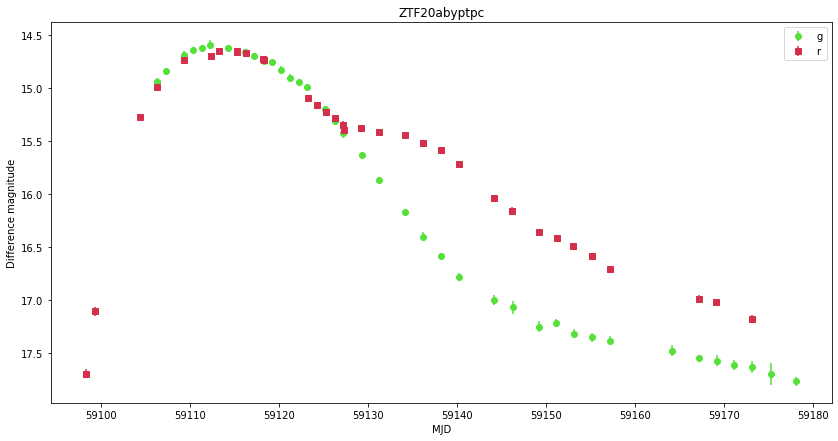

In [15]:
results = getobjdata(seloid, dets, doLC=True, diffmag=True)

Plot light curve using corrected magnitudes (including extinction correction) in the rest-frame, assuming the redshift of the closest NED match. Show the Aladin image

No.,Object Name,RA,DEC,Type,Velocity,Redshift,Redshift Flag,Magnitude and Filter,Separation,References,Notes,Photometry Points,Positions,Redshift Points,Diameter Points,Associations
,,degrees,degrees,,km / s,,,,arcmin,,,,,,,
int32,str30,float64,float64,object,float64,float64,object,object,float64,int32,int32,int32,int32,int32,int32,int32
1,WISEA J233838.69+155714.5,354.66122,15.95405,IrS,--,--,,,0.525,0,0,12,1,0,0,0
2,WISEA J233839.63+155649.3,354.66515,15.94705,IrS,--,--,,,0.514,0,0,12,1,0,0,0
3,SDSS J233840.03+155645.1,354.66681,15.94588,*,--,--,,21.1g,0.53,0,0,5,1,0,4,0
4,2MASS J23384067+1557228,354.6695,15.95634,IrS,--,--,,,0.146,0,0,6,1,0,0,0
5,SDSS J233840.88+155740.0,354.67035,15.96113,*,--,--,,18.4g,0.426,0,0,5,1,0,4,0
6,2MASS J23384109+1557281,354.67123,15.95783,IrS,--,--,,,0.234,0,0,4,1,0,0,0
7,NGC 7722,354.67169,15.95464,G,4026.0,0.013429,,13.3g,0.087,84,3,86,20,16,14,0
8,2MASS J23384137+1557140,354.67241,15.9539,IrS,--,--,,,0.122,0,0,4,1,0,0,0


'Redshift found: 0.013429'

Box(children=(Aladin(fov=0.04, layout=Layout(width='70%'), options=['allow_full_zoomout', 'coo_frame', 'fov', …

'Hover mouse to see information about catalog objects'

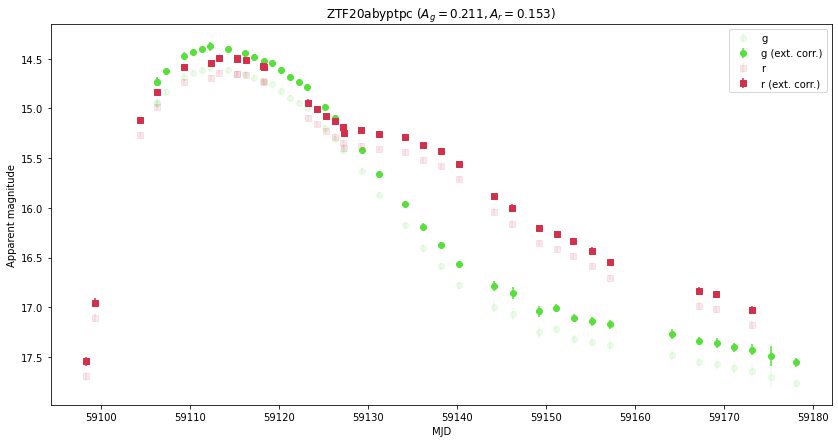

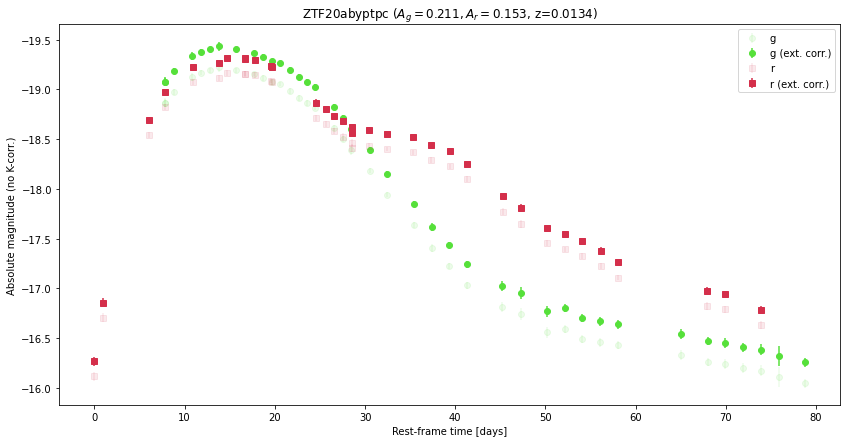

In [16]:
results = getobjdata(seloid, dets, doLC=True, doext=True, doNED=True, doredshift=True, showimage=True)

Close connection to DB

In [17]:
conn.close()